In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

In [32]:
data= pd.read_excel("./Flight_Fare.xlsx")

# Exploratory Data Analysis

In [33]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [34]:
data.tail()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2 stops,No info,11753


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [36]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [37]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [38]:
data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [39]:
data['Additional_Info'].value_counts()

Additional_Info
No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

In [40]:
data['Airline'].value_counts()

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

In [41]:
data['Source'].value_counts()

Source
Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

In [42]:
data['Destination'].value_counts()

Destination
Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

In [43]:
data['Total_Stops'].value_counts()

Total_Stops
1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [44]:
data[data['Airline'] == 'Jet Airways Business']['Additional_Info'].value_counts()

Additional_Info
No info           3
Business class    3
Name: count, dtype: int64

In [45]:
data.loc[data['Airline'] == "Multiple carriers Premium economy", 'Additional_Info'].value_counts()

Additional_Info
No info    13
Name: count, dtype: int64

In [46]:
data.loc[data['Airline'] == 'Vistara Premium economy', 'Additional_Info'].value_counts()

Additional_Info
No info    3
Name: count, dtype: int64

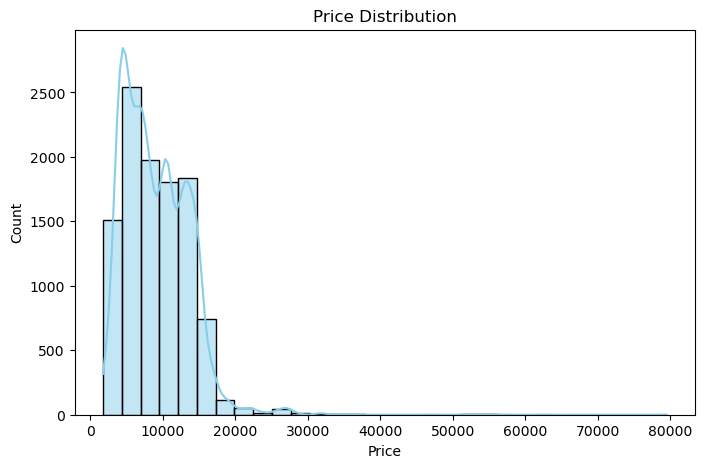

In [47]:
# Price Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['Price'], bins=30, kde=True, color='skyblue')
plt.title('Price Distribution')
plt.show()

# Preprocessing

## Remove Redundant Columns

In [48]:
# Route not needed since it's captured in Total_Stops and Arrival and Departure features
# Remove Arrival_Time as this is capture from Departure Time and Duration
data.drop(["Route", "Arrival_Time"], axis=1, inplace=True)

## Data with duplicate values because of casing

In [49]:
categorical_columns = ["Airline", "Source", "Destination", "Total_Stops", "Additional_Info"]
for col in categorical_columns:
    data[col] = data[col].str.lower().str.strip()

## Change Duplicate Records to the same

In [50]:
data.loc[data['Airline'] == 'jet airways business', 'Additional_Info'] = 'business class'
data.loc[data['Airline'] == 'jet airways business', 'Airline'] = 'jet airways'
data.loc[data['Airline'] == "multiple carriers premium economy", 'Additional_Info'] = 'premium economy class'
data.loc[data['Airline'] == "multiple carriers premium economy", 'Airline'] = 'multiple carriers'
data.loc[data['Airline'] == 'vistara premium economy', 'Additional_Info'] = 'premium economy class'
data.loc[data['Airline'] == 'vistara premium economy', 'Airline'] = 'vistara'
data.loc[data['Destination'] == 'new delhi', 'Destination'] = 'delhi'

## Impute Missing Values

In [51]:
data['Total_Stops'] = data['Total_Stops'].fillna(data['Total_Stops'].mode()[0])

## Encode Ordinal Data

In [52]:
encoder = OrdinalEncoder(categories=[["non-stop", "1 stop", "2 stops", "3 stops", "4 stops"]])
data['Total_Stops'] = encoder.fit_transform(data[['Total_Stops']])

## Date Conversion

In [53]:
def extract_duration(duration_str):
    """Extracts hours and minutes from a duration string.

    Args:
        duration_str: The duration string in the format "HHh MMm" or "HHh" or "MMm".

    Returns:
        A tuple containing the number of hours and minutes.
    """
    hours = 0
    minutes = 0
    if 'h' in duration_str:
        hours_str, rest = duration_str.split('h')
        hours = int(hours_str)
    if 'm' in duration_str:
        if 'h' in duration_str:
            minutes_str = rest.strip('m') 
        else:
            minutes_str = duration_str.strip('m')
        minutes = int(minutes_str)
    return hours, minutes

In [54]:
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')
# Extract day, month, year
data['Journey_day'] = data['Date_of_Journey'].dt.day
data['Journey_month'] = data['Date_of_Journey'].dt.month
data['Journey_year'] = data['Date_of_Journey'].dt.year
    
# Extract day of the week
data['Journey_day_of_week'] = data['Date_of_Journey'].dt.day_name() 

data['Dep_Time'] = pd.to_datetime(data['Dep_Time'], format='%H:%M')

# Extract hour and minute from 'Dep_Time'
data['Dep_hour'] = pd.to_datetime(data['Dep_Time']).dt.hour
data['Dep_min'] = pd.to_datetime(data['Dep_Time']).dt.minute
    
# Extract hours and minutes from 'Duration'
data['Duration_hours'], data['Duration_mins'] = zip(*data['Duration'].apply(extract_duration))
    
# Convert 'Duration_hours' and 'Duration_mins' to numeric
data['Duration_hours'] = data['Duration_hours'].astype(int)
data['Duration_mins'] = data['Duration_mins'].astype(int)
    
# Calculate total duration in minutes
data['Duration_total_mins'] = data['Duration_hours'] * 60 + data['Duration_mins'] 
    
# Drop original columns
data.drop(['Date_of_Journey', 'Dep_Time', 'Duration', 'Duration_hours', 'Duration_mins'], axis=1, inplace=True) 

### Check the distribution of years

In [93]:
data['Journey_year'].value_counts()

Journey_year
2019    10683
Name: count, dtype: int64

### Check the distribution of Duration of Total Minutes

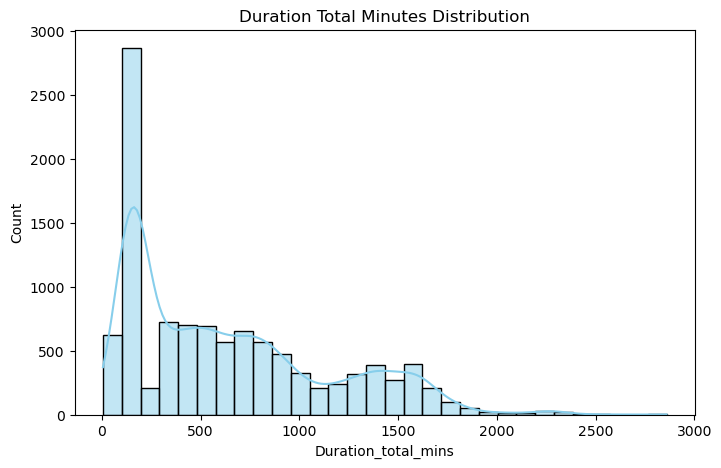

In [95]:
# Duration Total Minutes Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['Duration_total_mins'], bins=30, kde=True, color='skyblue')
plt.title('Duration Total Minutes Distribution')
plt.show()

## Encoding

In [55]:
data = pd.get_dummies(data, columns=['Airline', 'Source', 'Destination', 'Additional_Info', 'Journey_day_of_week'], drop_first=True)

In [82]:
bool_columns = data.select_dtypes(include=["bool"]).columns
data[bool_columns] = data[bool_columns].astype("int")

## Check for Homoscedasticity

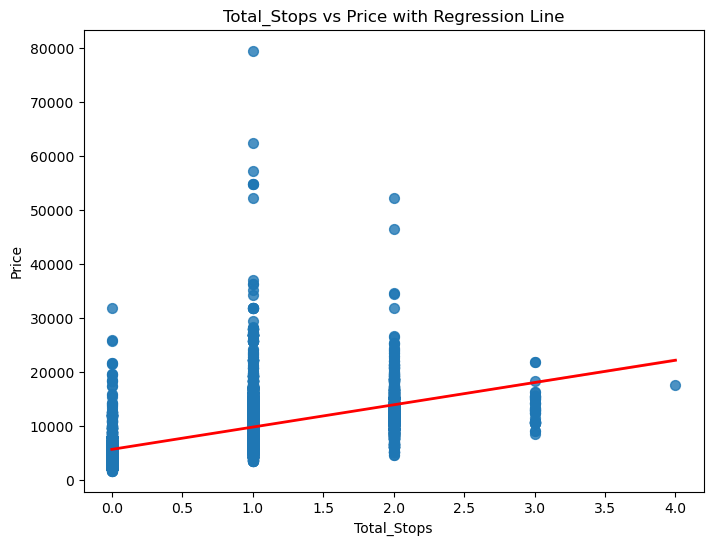

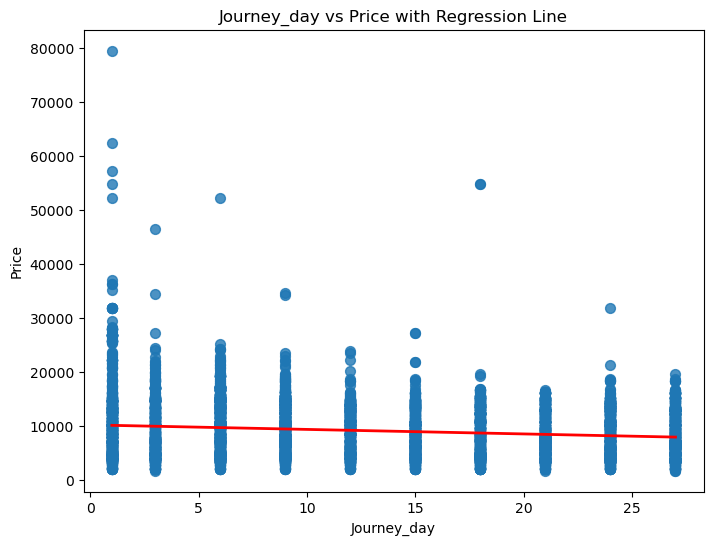

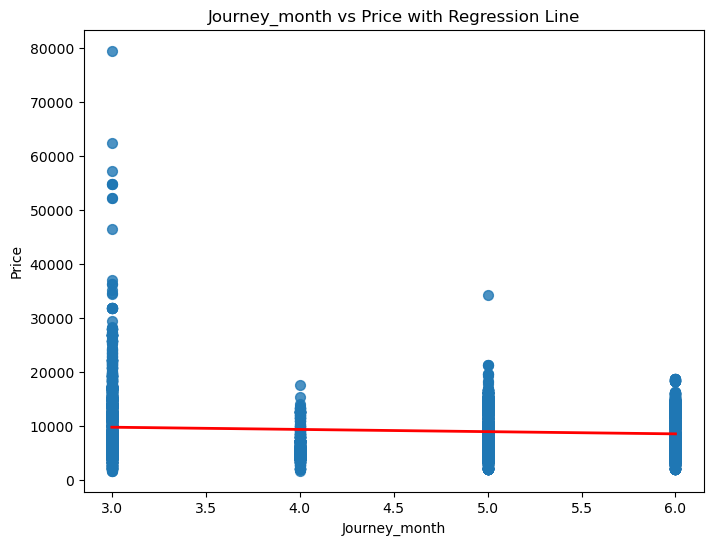

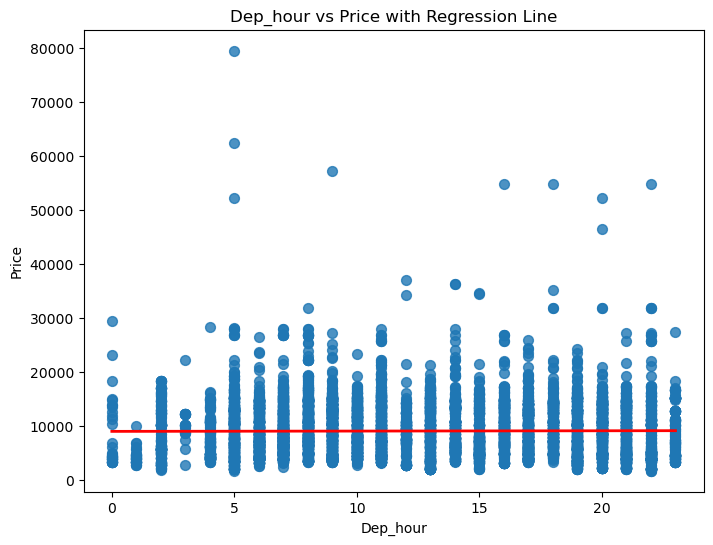

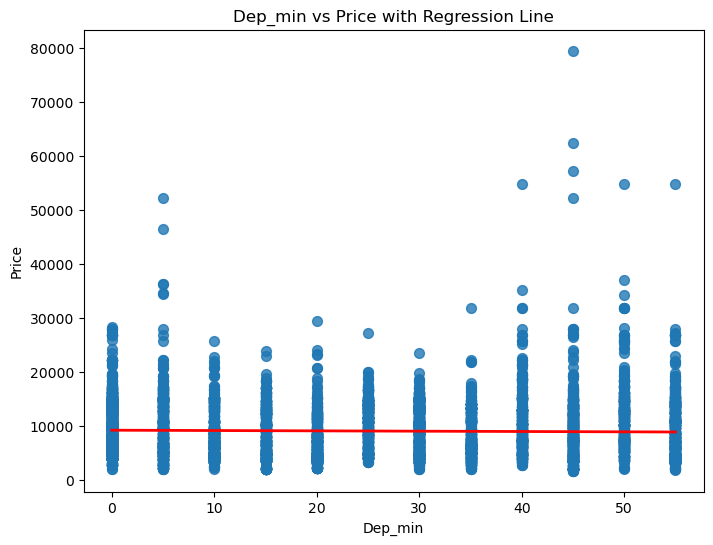

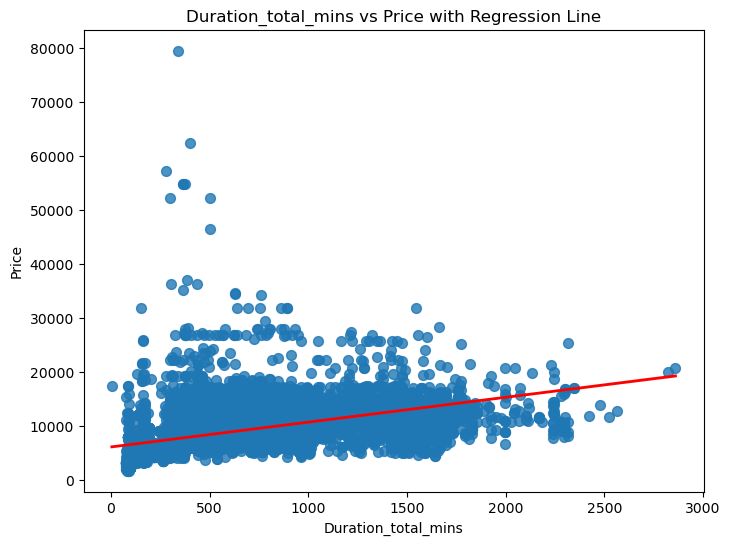

In [103]:
numeric_features = ["Total_Stops", "Journey_day", "Journey_month", "Dep_hour", "Dep_min", "Duration_total_mins"]
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feature, y='Price', data=data, scatter_kws={'s': 50}, line_kws={'color': 'red', 'lw': 2})
    plt.title(f'{feature} vs Price with Regression Line')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

In [96]:
## TODO: Apply Normalization on Total Minutes Distribution
from sklearn.preprocessing import MinMaxScaler

if 'Duration_total_mins' in data.columns:
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize the 'Duration_total_mins' column
    data['Normalized_Duration_mins'] = scaler.fit_transform(data[['Duration_total_mins']])

    # Check the result
    print(data[['Duration_total_mins', 'Normalized_Duration_mins']].head())

In [104]:
## TODO: Apply Log Transformation on Price 

In [105]:
## TODO: Apply PolynomialFeature to Total_Stops and rerun "Check for Homoscedasticity" to see if there's a line that fits perfect the data points
## with degree 4 or 5 for PolynomialFeature

# Training

In [85]:
X = data.drop("Price", axis=1)
Y  = data["Price"]
x = sm.add_constant(X)
est = sm.OLS(Y, x).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     714.8
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:38:55   Log-Likelihood:                -99045.
No. Observations:               10683   AIC:                         1.982e+05
Df Residuals:                   10649   BIC:                         1.984e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
p_values = est.pvalues
# Set a threshold for statistical significance (commonly 0.05)
significant_features = p_values[p_values < 0.05]
# Print the number of statistically significant features
print(f"Number of statistically significant features: {len(significant_features)}")

In [ ]:
## TODO: APPLY RFE with n_features as 31 


In [ ]:
from sklearn.feature_selection import RFE

X = data.drop(columns=['Price']) 
y = data['Price'] 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = RandomForestRegressor(random_state=42)

# Initialize RFE with the model and the desired number of features
rfe = RFE(estimator=model, n_features_to_select=31)

# Fit the RFE model on the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

# Print the selected features
print("Selected features:", selected_features)
X_train = X_train[selected_features]
X_test= X_test[selected_features]

In [142]:
# Initialize Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Model Performance
print("\nRandom Forest Model Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-Squared Value: {r2:.2f}")

# Note: You can extend this section to compare multiple models such as Linear Regression, Decision Tree, etc.


Model Evaluation:
Mean Squared Error: 3982401.771263707
R-Squared Value: 0.7696423643543975


In [ ]:
model=LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
# Model Performance
print("\nLinear Regression Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared Value: {r2:.2f}")

In [ ]:
model=GradientBoostingRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
# Model Performance
print("\nGradient Boosting Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared Value: {r2:.2f}")

In [ ]:
print("\nModel Evaluation:")
print(f"Mean Squared Error: {mse}")
print(f"R-Squared Value: {r2}")

In [102]:
## TODO: Some of the features are polynomial in nature and not Linear, please use Lasso, Ridge and GradientBostRegression with RandomSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Initialize models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Machine": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
}

# DataFrame to store model results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining and Evaluating: {model_name}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Cross-validation score (optional for robustness)
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    
    # Evaluation Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results in a dictionary
    results.append({
        'Model': model_name,
        'MSE': mse,
        'R2 Score': r2,
        'CV R2 Score': cv_score
    })
    
    # Print metrics for this model
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-Squared Score: {r2:.4f}")
    print(f"Cross-Validation R2 Score: {cv_score:.4f}")

# Convert results to a DataFrame for comparison
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
print("\nModel Performance Comparison:")
print(results_df)


Training and Evaluating: Linear Regression


NameError: name 'X_train' is not defined

In [101]:
## TODO: For Predict, do ResidualPlot 
## !pip install yellowbrick
## from yellowbrick.regressor import ResidualsPlot